<p>
 Mauricio Soroco </br>
 60785250 </br>
 Portfolio  object 6 - Mathematics 441</br>
 October 2022</br>
 </p>

# Implementing Branch and Bound for TSP with Different Heuristics

In this portfolio we implement the Branch and Bound algorithm to solve the Travelling Salesman Problem. We will compare the effects of different admissible heuristics and also compare these to the brute force method that we talked about in class. All of these methods will return an optimal solution if one exists.
This portfolio object is a follow-up to Portfolio 5 where we explain how the B&B algorithm works, how to apply it to the TSP, and what makes a heuristic admissible.

In [198]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

import timeit
import time
import sys


# Define TSP:

The two function below construct two datastuctures we need to search the problem.

In [199]:
# define a matrix that stores the distances between two nodes.
def cost_matrix(V):
    n = V.shape[0]
    C = np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            C[i,j] = la.norm(V[i,:] - V[j,:])
            C[j,i] = C[i,j]
    return C

In [200]:
# Computes the cost of a tour. Requires that 'tour' is a TSP tour 
#       and not simply a path.
def tour_cost(C, tour):
    n = len(tour)
    cost = 0
    for i in range(n-1):
        cost += C[tour[i],tour[i+1]]
    cost += C[tour[-1],tour[0]]
    return cost


# Define Heuristic Functions

In this we define three different admissible (see below) heuristics that we can use in Branch and Bound. Let $p$ be the node at the end of the current path. By definition, $h(\langle n_{0}, \cdots, n_{k}\rangle) = h(n_k)$.

#### Trivial Heuristic:
$$h(p) = 0$$

#### Nearest Neighbour Heuristic:
$$ h(p) = \min_i\{\text{dist}(p, ~i)\} ~~~ \forall \text{ unvisited nodes  } i$$

#### Furthest Neighbour Heuristic:
$$ h(p) = \max_i\{\text{dist}(p, ~i)\} ~~~ \forall \text{ unvisited nodes  } i$$
</br>
Finally we also define one non admissible heuristic to see what will happen. Non admissible heuristics should not be used in general for Branch and Bound:

#### Max Distance Heuristic:
$$ h(p) = \max_i\{\text{dist}(p, ~i)\} ~~~ \forall \text{ nodes  } i$$


In [201]:
# returns the 0 as as the heuristic
def trivial_heuristic(n, C, path):
    return 0

In [202]:
# returns the distance to the nearest neighbour node as the heuristic
def nearest_neighbor(n, C, path):
    if (len(path) == n + 1) and (path[0] == path[-1]):
        return 0 # goal node heuristic

    unvisited = list(range(n))
    for i in path:
        unvisited.remove(i)
    unvisited.append(path[0]) # include the start node for correct heuristic

    return np.nanmin(C[path[-1],unvisited]) 

In [203]:
# returns the distance to the furthest neighbour node as the heuristic
def furthest_neighbor(n, C, path):
    if (len(path) == n + 1) and (path[0] == path[-1]):
        return 0 # goal node heuristic

    unvisited = list(range(n))
    for i in path:
        unvisited.remove(i)
    unvisited.append(path[0]) # include the start node for correct heuristic

    return np.nanmax(C[path[-1],unvisited]) 

In [204]:
# returns the the largest distance between all nodes as the heuristic
#   Note: this heuristic is not admissible since it may ovestimate the
#           remaining path cost.
def non_admissible_max_distance_heuristic(n, C, path):
    all_nodes = list(range(n))
    return np.nanmax(C[path[-1], all_nodes]) 

## Discussion of Admissibility:

Recall from Portfolio 5:

A search <b>heuristic</b> $ℎ(𝑛)$ is an estimate of the cost of the lowest-cost path from node $𝑛$ to a goal node
Thus the heuristic of a path $h(\langle n_{0}, \cdots, n_{k}\rangle) = h(n_k).$ The heuristic at a goal node is always 0.
</br></br>
We say that a heuristic $ℎ(𝑛)$ is <b>admissible</b> if it never is an overestimate of the minimum actual cost from
$𝑛$ to a goal node. Hence an admissible $ℎ(𝑛)$ is a lower bound on the cost of getting from $𝑛$ to the
nearest goal. This property is very important for the algorithm to work well.

#### The Furthest Neighbour:
We claim that the furthest neighbour heuristic is admissible for following reasons. For any node that is remaining, we need to
incur a cost to visit that node eventually (the start node included). If the start node is the only remaining
node, then the heuristic at node $p$ is exactly the maximum cost from $p$ to a goal node (since it’s the only
cost from $p$). If there are multiple nodes that remain to be visited, then the distance to visit just the
furthest one, $ℎ(p)$, is less than the distance of any path that travels through all the remaining nodes due
to the triangle inequality. Thus, the heuristic is admissible since:
$$ℎ(p) ≤ max(\text{dist}(\langle p,  n_{i_1}, \cdots, n_{i_k} \rangle) ~~~~~~ \text{         where} ~ 𝑘 \text{ nodes remain }$$

</br>

#### The Nearest Neighbour:
Since the nearest neighbour heuristic is bounded above by the furthest neighbour heuristic:
$$ \min_i\{\text{dist}(p, ~i)\}  \leq \max_i\{\text{dist}(p, ~i)\} ~~~ \forall \text{ unvisited nodes  } i$$

and the furthest neighbour heuristic is admissible (as shown above), then the nearest neighbour heuristic is also admissible.

</br>

#### The Trivial (zero) Heuristic:

As above, the trivial heuristic is bounded above by an admissible heuristic and thus is admissible.


#### Non-admissibility of the Max distance heurisitic:

There is no guarantee with this heuristic that the largest distance between *any* two nodes will be less than the remaining path. Imagine two adjacent nodes that are very close together such that one is the start node, and the other is the current node on the TSP tour. Then there is no reason why the distance between these adjacent nodes can't be smaller than the largest distance between any pair of nodes in the problem. Thus we cannot say that this heuristic is admissible. In the results below we show why this may be a problem.


# Branch and Bound Algorithm:

Below is the branch and bound algorithm as well as the multiple helper functions we use to set up and evaulate the problem.
Given that we are solving the TSP, a slight adjustment was made to the Branch and Bound algorithm compared to as discussed in Portfolio 5 (see code comments).
</br>
</br>
I also added a counter to show how many branches in the search tree were pruned. The less branches that are pruned, the more efficient the algorithm performs. This is because in a search tree, if we prune branches closer to the root node, we remove larger chuncks of the tree at a time thus saving us having to prune other branches of that subtree. Having to prune a large number of branches indicates that we searched deep into the tree thus leaving us with multiple branches that we explored.

In [205]:
# construct the f-score function. The f-score for each node is given by:
#      f(path) = cost(path) + h(path)
#
def get_f(V, C, heuristic_function):
    n = V.shape[0]
    def f_score(path):
        f = path_cost(C, path) + heuristic_function(n, C, path)
        return f
    return f_score


# Returns true if path constitues a tour (ie is a goal node).
def get_goal(V, start):
    def goal(path):
        if len(path) == len(V) + 1:
            for i in range(len(V)):
                if i not in path:
                    return False
            return path[0] == path[-1] and path[-1] == start
    return goal


# returns the current cost of the given path.
def path_cost(C, path):
    n = len(path)
    cost = 0
    for i in range(n-1):
        cost += C[path[i],path[i+1]]
    return cost


# Given the current path, finds all possible nodes that path could visit next
# in TSP, this is all the unvisited nodes. In the case where all nodes are visited
# the only and remaining neighbour is the start node. In the case that there other
# unvisited nodes, the start node is not considered a neighbour since it needs to
# be visited last.
def get_neighbours(path, V):
    neighbours = []

    if len(path) == len(V): # if all nodes traversed, neighbour is only the start node
        neighbours.append(path[0])
        return neighbours

    neighbours = list(range(V.shape[0]))
    for i in path:
        neighbours.remove(i)
    return neighbours


# Finds the optimal tour of a set of given TSP nodes using Branch and Bound.
# A path is a permutation of numbers in [0, len(V) ).
# 'V' is the set of nodes and their coordinates (from which we can construct the 
#       cost of each path which is proportional to the distances between nodes).
# 'start' is the start node.
# 'f-score' is the function to use to evaulate the f-score of the current path
#       this is dependent on the choice of heuristic function. Cost is always 
#       proportional to distance.
def Branch_and_Bound(V, start, f_score):
    goal = get_goal(V, start) # initialize goal function
    C = cost_matrix(V)
    paths_pruned = 0 # count of how many times we prune
    S = [] # stack
    UB = np.inf # upper bound for pruning
    solution = []
    start_path = [start]
    S.append(start_path)

    while (S != []):
        path = S.pop()
        if f_score(path) < UB:
            if goal(path):
                UB = tour_cost(C, path)
                solution = path
            else: # normally 'else' wouldn't exist but we know there are no paths past a goal in TSP (tour).
                neighbours = get_neighbours(path, V)
                for n in neighbours:
                    new_path = path.copy()
                    new_path.append(n)
                    S.append(new_path)
        else:
            paths_pruned += 1
    return solution, UB, paths_pruned


# Initialize TSP
Below we show an instance of the Traveling Salesman Problem with 11 nodes.

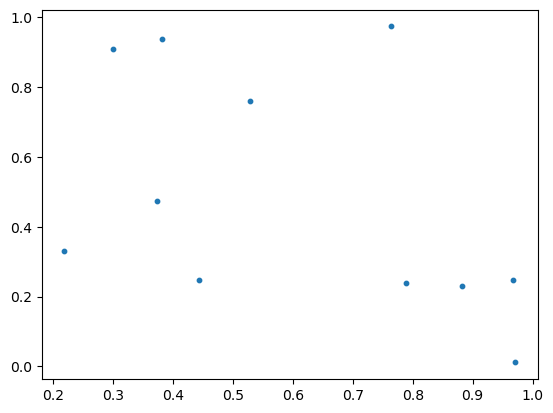

<Figure size 640x480 with 0 Axes>

In [206]:
# initialize problem
n = 11
V = np.random.rand(n,2)
plt.scatter(V[:,0],V[:,1],s=10)
plt.show()
plt.savefig("initial scatter")

In [207]:
# Plot the tour given a set of vertices and an ordering of indices. Figure saved with title.
def plot_tour(V,tour, title):
    n = len(tour)
    for i in range(n-1):
        plt.plot([V[tour[i],0],V[tour[i+1],0]],[V[tour[i],1],V[tour[i+1],1]],'b')
    plt.plot([V[tour[-1],0],V[tour[0],0]],[V[tour[-1],1],V[tour[0],1]],'b')
    plt.scatter(V[:,0],V[:,1],s=10)
    plt.show()
    plt.savefig(title)

# Run Solvers:

## Branch and Bound:

#### Trivial Heuristic

time for B&B with the Trivial Heuristic: 6.890768051147461 seconds
optimal cost: 3.187709550737371
number of branches pruned: 494688



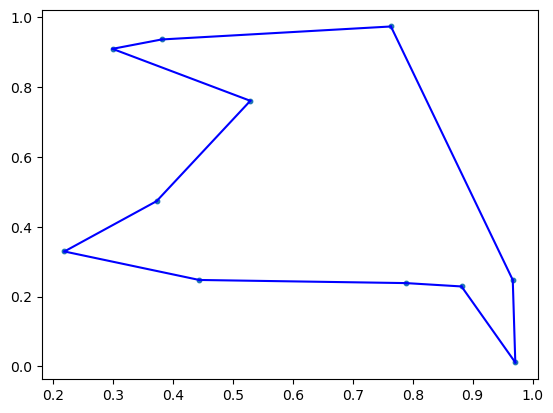

<Figure size 640x480 with 0 Axes>

In [208]:
t0 = time.time()
C = cost_matrix(V)
f = get_f(V, C, trivial_heuristic)
optimal_tour, optimal_cost, paths_pruned = Branch_and_Bound(V, 0, f)
t1 = time.time()
print("time for B&B with the Trivial Heuristic: " + str(t1- t0) + " seconds")
print("optimal cost: " + str(optimal_cost))
print("number of branches pruned: " + str(paths_pruned) + '\n')
plot_tour(V,optimal_tour, "B&B_furthest")

#### Nearest Neighbour heuristic:

time for B&B with Nearest Neighbour Heuristic: 12.236494302749634 seconds
optimal cost: 3.187709550737371
number of branches pruned: 298727



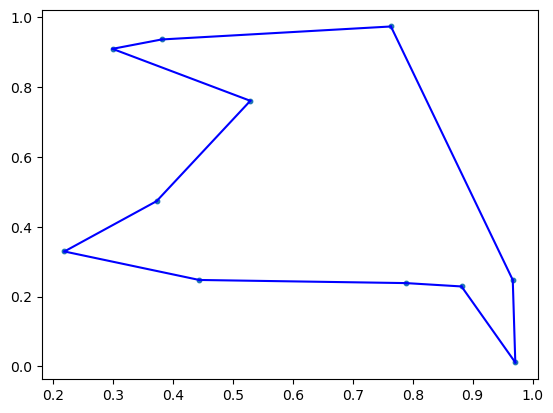

<Figure size 640x480 with 0 Axes>

In [209]:
t0 = time.time()
C = cost_matrix(V)
f = get_f(V, C, nearest_neighbor)
optimal_tour, optimal_cost, paths_pruned = Branch_and_Bound(V, 0, f)
t1 = time.time()
print("time for B&B with Nearest Neighbour Heuristic: " + str(t1- t0) + " seconds")
print("optimal cost: " + str(optimal_cost))
print("number of branches pruned: " + str(paths_pruned) + '\n')
plot_tour(V,optimal_tour, "BnB_nearest")

#### Furthest Neighbour heuristic:

time for B&B with Furthest Neighbour Heuristic: 2.575488805770874 seconds
optimal cost: 3.187709550737371
number of branches pruned: 65751



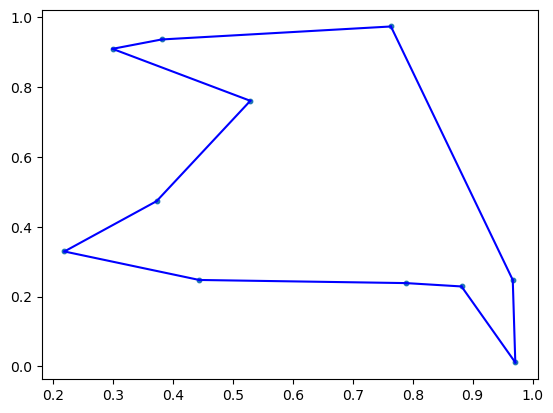

<Figure size 640x480 with 0 Axes>

In [210]:
t0 = time.time()
C = cost_matrix(V)
f = get_f(V, C, furthest_neighbor)
optimal_tour, optimal_cost, paths_pruned = Branch_and_Bound(V, 0, f)
t1 = time.time()
print("time for B&B with Furthest Neighbour Heuristic: " + str(t1- t0) + " seconds")
print("optimal cost: " + str(optimal_cost))
print("number of branches pruned: " + str(paths_pruned) + '\n')
plot_tour(V,optimal_tour, "B&B_furthest")

## Brute Force Method
This is a copy of Patrick's Brute Force method (that we saw in class) for finding optimal tour:

In [211]:
from itertools import permutations

def cost_matrix(V):
    n = V.shape[0]
    C = np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            C[i,j] = la.norm(V[i,:] - V[j,:])
            C[j,i] = C[i,j]
    return C

def tour_cost(C,tour):
    n = len(tour)
    cost = 0
    for i in range(n-1):
        cost += C[tour[i],tour[i+1]]
    cost += C[tour[-1],tour[0]]
    return cost

def brute_force(V):
    n = V.shape[0]
    tours = permutations(range(n))
    C = cost_matrix(V)
    optimal_cost = None
    for tour in tours:
        cost = tour_cost(C,tour)
        if optimal_cost is None or cost < optimal_cost:
            optimal_cost = cost
            optimal_tour = np.array(tour)
    return optimal_tour,optimal_cost

time for brute force: 255.2985291481018 seconds
optimal cost: 3.187709550737371



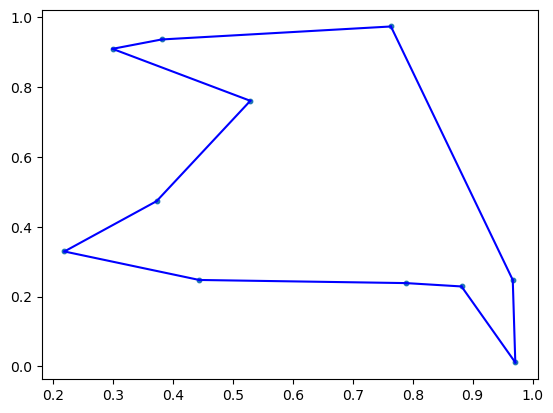

<Figure size 640x480 with 0 Axes>

In [212]:
t0 = time.time()
optimal_tour, optimal_cost = brute_force(V)
t1 = time.time()
print("time for brute force: " + str(t1- t0) + " seconds")
print("optimal cost: " + str(optimal_cost) + '\n')
plot_tour(V,optimal_tour, "Brute_force")

## Branch and Bound
#### <b>Non-Admissible</b> Maximum Distance Heuristic

time for B&B with non admissible Max Distance Heuristic: 5.7851362228393555 seconds
optimal cost: 3.5622714328029255
number of branches pruned: 155030



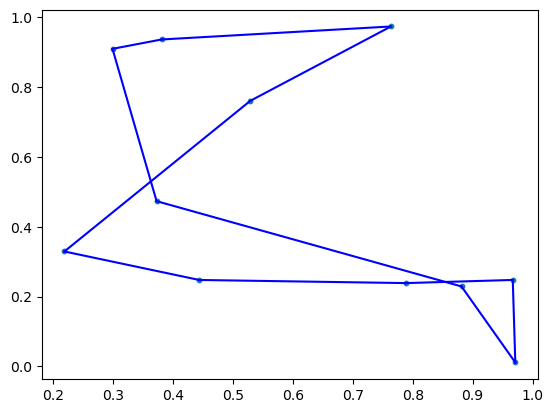

<Figure size 640x480 with 0 Axes>

In [213]:
t0 = time.time()
C = cost_matrix(V)
f = get_f(V, C, non_admissible_max_distance_heuristic)
optimal_tour, optimal_cost, paths_pruned = Branch_and_Bound(V, 0, f)
t1 = time.time()
print("time for B&B with non admissible Max Distance Heuristic: " + str(t1- t0) + " seconds")
print("optimal cost: " + str(optimal_cost))
print("number of branches pruned: " + str(paths_pruned) + '\n')
plot_tour(V,optimal_tour, "BnB_nearest")

# Discussion:

Firstly we see that all method with an admissible heuristic, and the brute force method returned the optimal tour for this TSP. In terms of the runtime, for 11 nodes, we see that the Furthest Neighbour heuristic performed the best, then the trivial heuristic, the nearest neighbour heuristic, and finally the Brute force method.
</br>
</br>
What separates the heuristics is that the heuristic that best approximates the actual path cost performs the best. In other words, a good heuristic is one that is as large as possible without overestimating the remaining path cost.
</br>
The non-admissible heuristic shows what may happen otherwise--you may prune an optimal branch thinking it's suboptimal due to the f-score = (current_path_cost + h(path) ) overestimating the actual total path cost. It also happened that the runtime did not even improve from the Furthest Neighbour heuristic.
</br>
</br>
It is interesting that the trivial heuristic ran faster than the nearest neighbour heuristic especially since the trivial heuristic pruned more branches (and thus searched deeper in the tree). It is possible that computing the minimum neighbour heuristic for less branches took longer than the time necessary to traverse a larger number of branches (due to the worse f-score of the trivial heuristic).
</br>
We see that Furthest Neighbour run pruned the least amound of branches (meaning it was able to prune off larger subtrees leaving less for it to traverse). Thus, having traversed the least amount of the tree, contributed to its speed.